In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
torch.__version__

'1.12.1+cu102'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import scipy

import torch.nn as nn
import torch.distributions as TD
from torch.utils.data import DataLoader

import os
import sys
sys.path.append('..')

# SET UP YOUR DEVICE
if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from dgm_utils import train_model
from dgm_utils import StatsManager, StatsManagerDrawScheduler

# other utils
from src.utils import make_numpy
from src.utils import Distrib2Sampler, JointSampler
from src.utils import DataLoaderWrapper
from src.utils import Config
from src.models2D import FullyConnectedMLP, FullyConnectedMLPwithConfig

# discrete OT
DISCRETE_OT_DIR = '../src/discreteot'
sys.path.append(DISCRETE_OT_DIR)
from src.discreteot import load_discrete_ot, store_discrete_ot, DiscreteEOT_l2sq

# EOT
from src.eot import EOT_l2sq_Mixin
from src.eot import SampleBufferEOT


# Energy-based Entropic OT for Gaussian $\rightarrow$ Swissroll mapping. TRAINING.

Partially based on IGEBM [Du & Mordatch et. al.](https://arxiv.org/pdf/1903.08689.pdf)

The code is partially taken from [github](https://github.com/rosinality/igebm-pytorch)

### Entropic Optimal transport for $c(x, y) = \frac{1}{2} \Vert x - y \Vert_2^2$

In [4]:
class EOT_l2sq(EOT_l2sq_Mixin, FullyConnectedMLPwithConfig):

    def __init__(self, sample_buffer, config, 
        hiddens=[256, 256, 256],
        activation = lambda : nn.LeakyReLU(0.2)):
        super().__init__(sample_buffer, config, 2, hiddens, 1, activation_gen=activation) # MLP parameters

### Gaussian2SwissRoll

Set up distribution

In [5]:
from sklearn.datasets import make_swiss_roll

def sample_swiss_roll(size, noise=0.5, normalization=10.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / normalization

def train_test_split(data):
    count = data.shape[0]
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

class SwissRollSampler:

    def __init__(self, noise=0.5, normalization=10.0, device=DEVICE):
        self.noise = noise
        self.normalization = normalization
        self.DEVICE = DEVICE
    
    def sample(self, bs):
        np_sample = sample_swiss_roll(
            bs, noise=self.noise, normalization=self.normalization)
        return torch.tensor(np_sample).float().to(self.DEVICE)


In [6]:
StdGauss_distrib = TD.Normal(
    torch.tensor([0., 0.]).to(DEVICE),
    torch.tensor([1., 1.]).to(DEVICE)
)

StdGauss_sampler = Distrib2Sampler(StdGauss_distrib)
SwissRoll_sampler = SwissRollSampler(normalization=8.0)

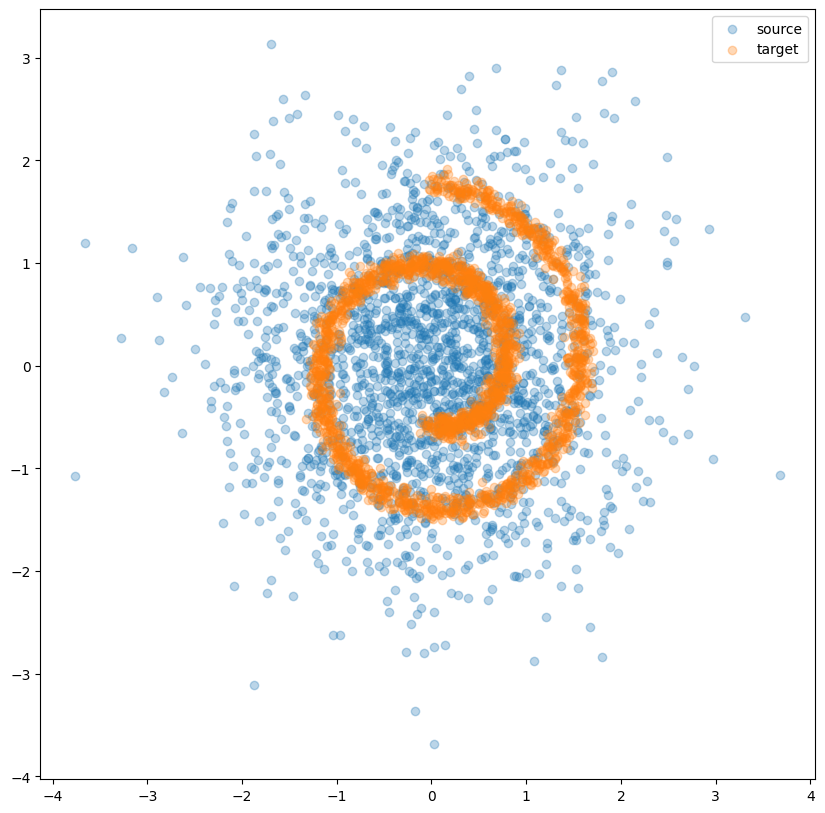

In [7]:
Xsample = StdGauss_sampler.sample(2000).detach().cpu().numpy()
Ysample = SwissRoll_sampler.sample(2000).detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.scatter(Xsample[:, 0], Xsample[:, 1], label='source', alpha=0.3)
plt.scatter(Ysample[:, 0], Ysample[:, 1], label='target', alpha=0.3)
plt.legend()
plt.show()

## Entropic Optimal Transport with $\varepsilon = 0.1$

#### Config

In [7]:
CONFIG = Config()

CONFIG.CLIP_GRADS_NORM = False
CONFIG.ALPHA = 0.000 # loss += alpha * (pos_out ** 2 + neg_out ** 2)
CONFIG.HREG = 0.1

CONFIG.ENERGY_SAMPLING_METHOD = 'langevin_classic' #'classic', 'pseudo'

CONFIG.LANGEVIN_THRESH = None
CONFIG.LANGEVIN_SAMPLING_NOISE = 0.05
CONFIG.ENERGY_SAMPLING_ITERATIONS = 100
CONFIG.LANGEVIN_DECAY = 1.0
CONFIG.LANGEVIN_SCORE_COEFFICIENT = 1.0
CONFIG.LANGEVIN_COST_COEFFICIENT = CONFIG.LANGEVIN_SAMPLING_NOISE ** 2
CONFIG.ENERGY_SAMPLING_STEP = 1.0
CONFIG.SPECTRAL_NORM_ITERS = 0
CONFIG.REFERENCE_DATA_NOISE_SIGMA = 0.00
CONFIG.P_SAMPLE_BUFFER_REPLAY = 0.95
CONFIG.ENERGY_SAMPLING_NO_PROJECT_DATA = True

CONFIG.PSEUDO_LANGEVIN_GRAD_PROJ_TYPE = 'none' # 'value', 'norm', 'none'
CONFIG.PSEUDO_LANGEVIN_NORM_THRESH = 1.
CONFIG.PSEUDO_LANGEVIN_VALUE_THRESH = 0.01
CONFIG.PSEUDO_LANGEVIN_NOISE = 0.005

# learning parameters
CONFIG.EPOCHS = 200
CONFIG.BATCH_SIZE = 1024
CONFIG.LR = 2e-3
USE_CUDA = True
CONFIG.SAMPLE_BUFFER_SAMPLES = 10000
CONFIG.BASIC_NOISE_VAR = 1.0

#### Training

In [9]:
################

basic_noise_gen = TD.Normal(
    torch.tensor([0., 0.]).to(DEVICE), 
    torch.tensor([1., 1.]).to(DEVICE) * CONFIG.BASIC_NOISE_VAR)

sample_buffer_instance = SampleBufferEOT(
    basic_noise_gen, max_samples=CONFIG.SAMPLE_BUFFER_SAMPLES)

gauss2swiss_eot = EOT_l2sq(
    sample_buffer_instance,
    CONFIG)

train_loader = DataLoaderWrapper(
    JointSampler(StdGauss_sampler, SwissRoll_sampler),
    CONFIG.BATCH_SIZE, n_batches=100)

test_loader = DataLoaderWrapper(
    JointSampler(StdGauss_sampler, SwissRoll_sampler),
    CONFIG.BATCH_SIZE, n_batches=20, store_dataset=True)

from dgm_utils.scheduler import TrainingSchedulerSM_Mixin

train_model(
    gauss2swiss_eot, 
    train_loader, 
    test_loader, 
    epochs=CONFIG.EPOCHS, 
    lr=CONFIG.LR,
    adam_betas=(0.2, 0.99),
    use_tqdm=True, 
    use_cuda=USE_CUDA,
    loss_key='loss',
    conditional=True,
    scheduler = TrainingSchedulerSM_Mixin(SMscheduler = StatsManagerDrawScheduler(
        StatsManager(), 4, 2, (12, 10), epoch_freq=3))
)

#### Loading pretrained model

In [12]:
file_name = 'gaussian2swissroll_hreg_0.1.pth'
path = os.path.join('../pretrained/gauss2swissroll/', file_name)
CP = torch.load(path, map_location=DEVICE)


rec_config = CP['config']

basic_noise_gen = TD.Normal(
    torch.tensor([0., 0.]).to(DEVICE), 
    torch.tensor([1., 1.]).to(DEVICE) * rec_config.BASIC_NOISE_VAR)

sample_buffer_instance = SampleBufferEOT(
    basic_noise_gen, max_samples=rec_config.SAMPLE_BUFFER_SAMPLES)

gauss2swiss_eot = EOT_l2sq(
    sample_buffer_instance,
    rec_config)

gauss2swiss_eot.load_state_dict(CP['state_dict'])
gauss2swiss_eot = gauss2swiss_eot.to(DEVICE)

Visualization of samples from $\hat{\pi}(y)$ and $\hat{\pi}(\cdot | x)$ for several $x$'s

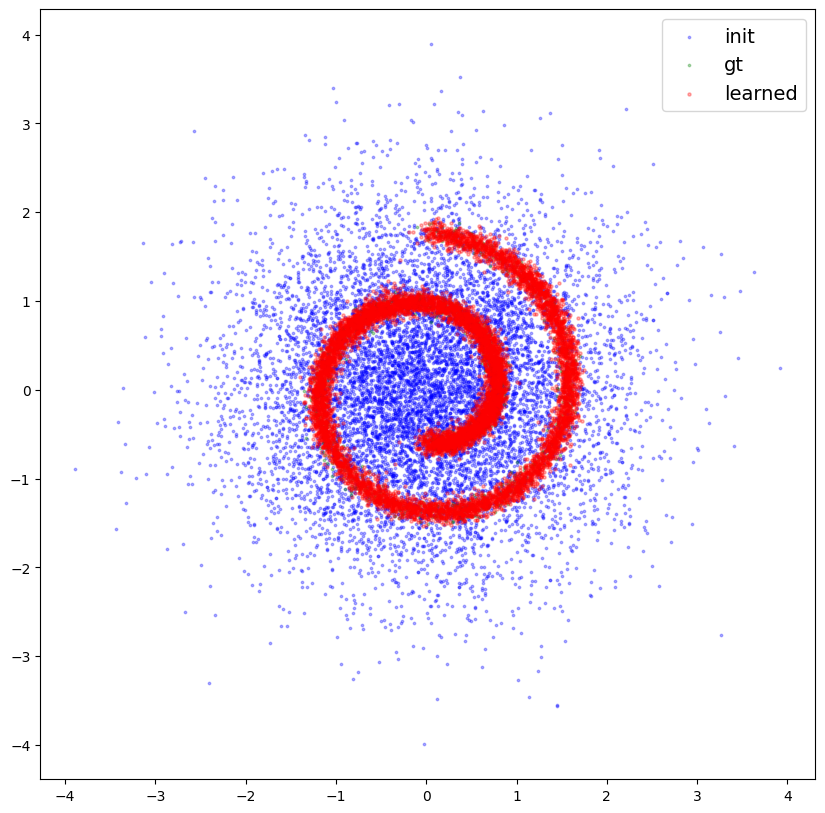

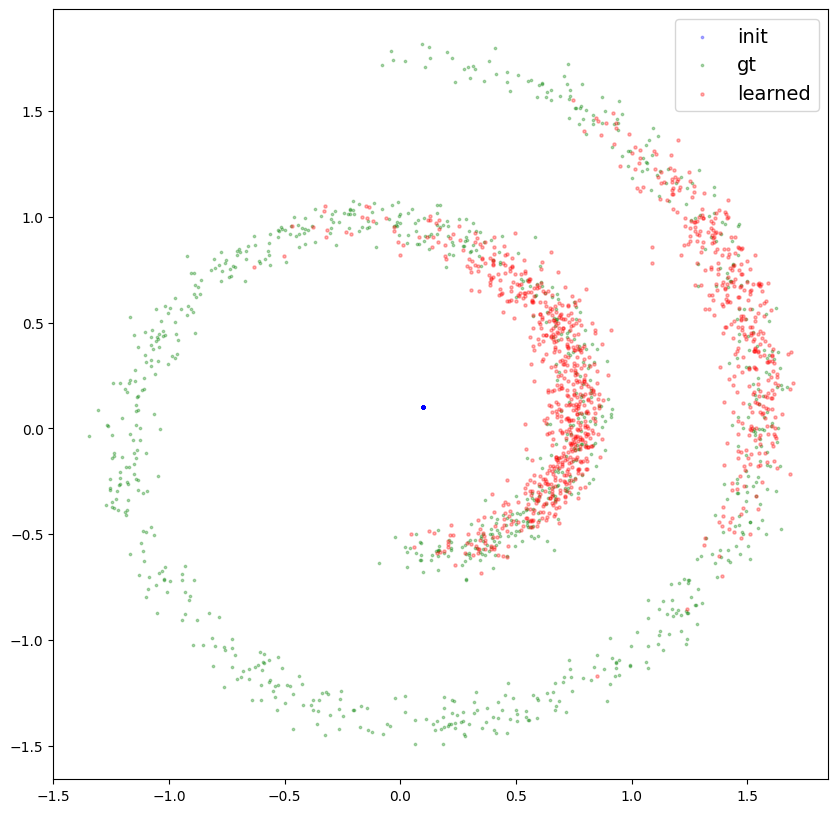

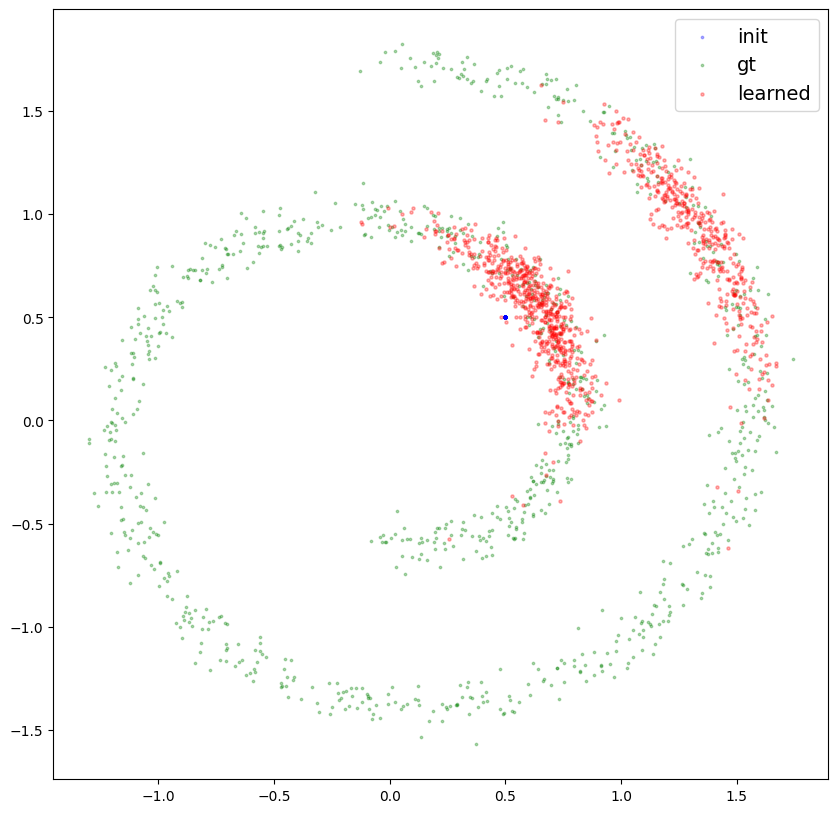

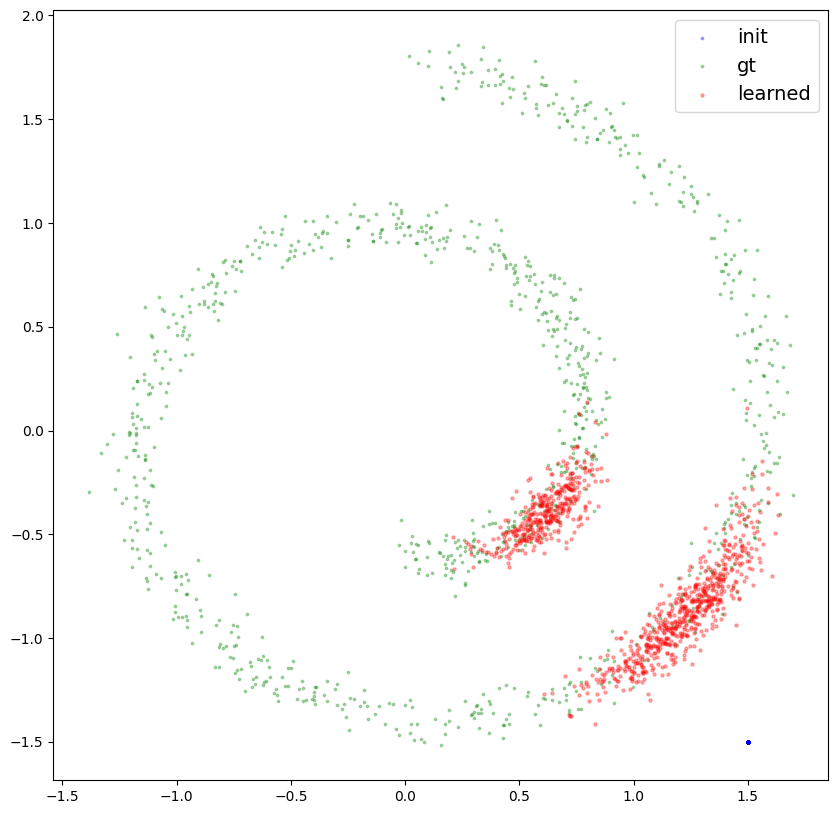

In [11]:
Xs = [
    StdGauss_sampler.sample(10000), 
    torch.tensor([[0.1, 0.1]]).to(DEVICE).repeat_interleave(1000, 0),
    torch.tensor([[0.5, 0.5]]).to(DEVICE).repeat_interleave(1000, 0),
    torch.tensor([[1.5, -1.5]]).to(DEVICE).repeat_interleave(1000, 0)]
for X in Xs:
    Y = gauss2swiss_eot.sample(X, n_iterations=5000, init_sampler=Distrib2Sampler(basic_noise_gen))
    np_Y_gt = SwissRoll_sampler.sample(1000).detach().cpu().numpy()
    np_X = X.detach().cpu().numpy()
    np_Y = Y.detach().cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.scatter(np_X[:, 0], np_X[:, 1], label='init', alpha=0.3, s=3, color='blue')
    plt.scatter(np_Y_gt[:, 0], np_Y_gt[:, 1], label='gt', alpha=0.3, s=3, color='green')
    plt.scatter(np_Y[:, 0], np_Y[:, 1], label='learned', alpha=0.3, s=5, color='red')
    plt.legend(fontsize=14)
    plt.show()

### Discrete `OT` based on `sinkhorn` (as the baseline method)

In [33]:
X = StdGauss_sampler.sample(10000)
Y = SwissRoll_sampler.sample(10000)

In [34]:
discr_eot = DiscreteEOT_l2sq(dtype='torch64', numItermax=10000, device=DEVICE).solve(X, Y, 1e-1)

#### Loading pretrained DOT model

In [11]:
file_name = 'discrete_gaussian2swissroll_hreg_0.1'
path = os.path.join('../pretrained/gauss2swissroll/', file_name)
discr_eot = load_discrete_ot(path)

Conditional sampling visuzalisation

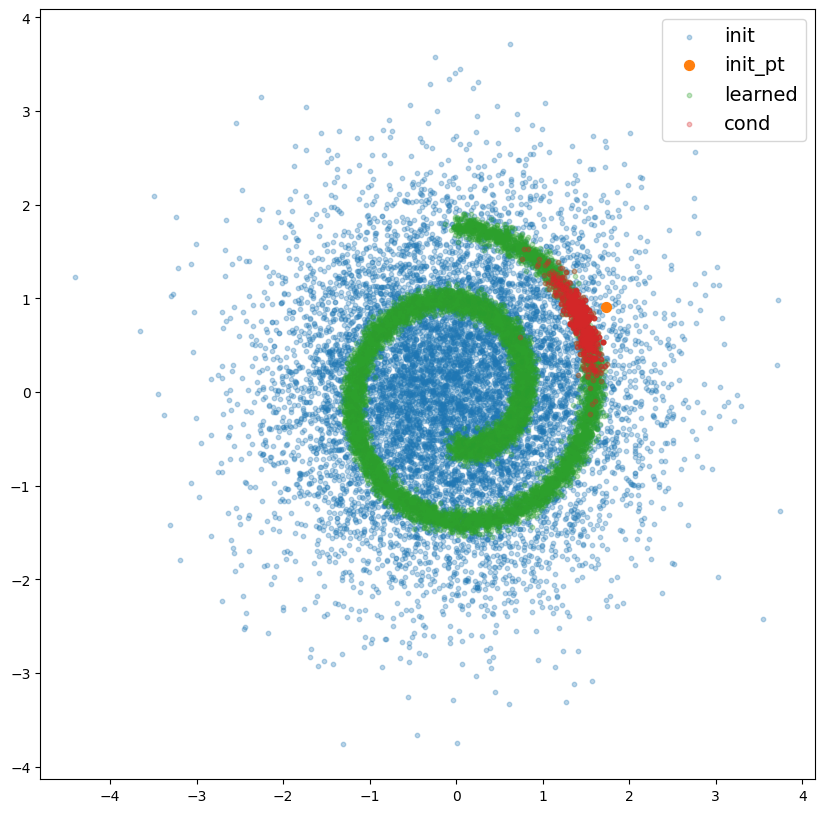

In [13]:
X = discr_eot.X
Y = discr_eot.Y

pt_index = 2
Y_X = discr_eot.sample_by_index(pt_index, 1000)

plt.figure(figsize=(10, 10))
plt.scatter(make_numpy(X)[:, 0], make_numpy(X)[:, 1], label='init', alpha=0.3, s=10)
plt.scatter(make_numpy(X[pt_index])[0], make_numpy(X[pt_index])[1], label='init_pt', s=50)
plt.scatter(make_numpy(Y)[:, 0], make_numpy(Y)[:, 1], label='learned', alpha=0.3, s=10)
plt.scatter(make_numpy(Y_X)[:, 0], make_numpy(Y_X)[:, 1], label='cond', alpha=0.3, s =10)
plt.legend(fontsize=14)
plt.show()

## Entropic Optimal Transport with $\varepsilon = 0.001$

In [13]:
CONFIG = Config()

CONFIG.CLIP_GRADS_NORM = False
CONFIG.ALPHA = 0.000 # loss += alpha * (pos_out ** 2 + neg_out ** 2)
CONFIG.HREG = 0.001

CONFIG.ENERGY_SAMPLING_METHOD = 'langevin_classic' #'classic', 'pseudo'

CONFIG.LANGEVIN_THRESH = None
CONFIG.LANGEVIN_SAMPLING_NOISE = 0.005
CONFIG.ENERGY_SAMPLING_ITERATIONS = 100
CONFIG.LANGEVIN_DECAY = 1.0
CONFIG.LANGEVIN_SCORE_COEFFICIENT = 1.0
CONFIG.LANGEVIN_COST_COEFFICIENT = CONFIG.LANGEVIN_SAMPLING_NOISE ** 2
CONFIG.ENERGY_SAMPLING_STEP = 1.0
CONFIG.SPECTRAL_NORM_ITERS = 0
CONFIG.REFERENCE_DATA_NOISE_SIGMA = 0.00
CONFIG.P_SAMPLE_BUFFER_REPLAY = 0.95
CONFIG.ENERGY_SAMPLING_NO_PROJECT_DATA = True

CONFIG.PSEUDO_LANGEVIN_GRAD_PROJ_TYPE = 'none' # 'value', 'norm', 'none'
CONFIG.PSEUDO_LANGEVIN_NORM_THRESH = 1.
CONFIG.PSEUDO_LANGEVIN_VALUE_THRESH = 0.01
CONFIG.PSEUDO_LANGEVIN_NOISE = 0.005

# learning parameters
CONFIG.EPOCHS = 200
CONFIG.BATCH_SIZE = 1024
CONFIG.LR = 2e-3
USE_CUDA = True
CONFIG.SAMPLE_BUFFER_SAMPLES = 10000
CONFIG.BASIC_NOISE_VAR = 1.0

In [15]:
basic_noise_gen = TD.Normal(
    torch.tensor([0., 0.]).to(DEVICE), 
    torch.tensor([1., 1.]).to(DEVICE) * CONFIG.BASIC_NOISE_VAR)

sample_buffer_instance = SampleBufferEOT(
    basic_noise_gen, max_samples=CONFIG.SAMPLE_BUFFER_SAMPLES)

gauss2swiss_eot = EOT_l2sq(
    sample_buffer_instance,
    CONFIG)

train_loader = DataLoaderWrapper(
    JointSampler(StdGauss_sampler, SwissRoll_sampler),
    CONFIG.BATCH_SIZE, n_batches=100)

test_loader = DataLoaderWrapper(
    JointSampler(StdGauss_sampler, SwissRoll_sampler),
    CONFIG.BATCH_SIZE, n_batches=20, store_dataset=True)

from dgm_utils.scheduler import TrainingSchedulerSM_Mixin

train_model(
    gauss2swiss_eot, 
    train_loader, 
    test_loader, 
    epochs=CONFIG.EPOCHS, 
    lr=CONFIG.LR,
    adam_betas=(0.2, 0.99),
    use_tqdm=True, 
    use_cuda=USE_CUDA,
    loss_key='loss',
    conditional=True,
    scheduler = TrainingSchedulerSM_Mixin(SMscheduler = StatsManagerDrawScheduler(
        StatsManager(), 4, 2, (12, 10), epoch_freq=3))
)

#### Loading pretrained model

In [24]:
file_name = 'gaussian2swissroll_hreg_0.001.pth'
path = os.path.join('../pretrained/gauss2swissroll/', file_name)
CP = torch.load(path, map_location=DEVICE)


rec_config = CP['config']

basic_noise_gen = TD.Normal(
    torch.tensor([0., 0.]).to(DEVICE), 
    torch.tensor([1., 1.]).to(DEVICE) * rec_config.BASIC_NOISE_VAR)

sample_buffer_instance = SampleBufferEOT(
    basic_noise_gen, max_samples=rec_config.SAMPLE_BUFFER_SAMPLES)

gauss2swiss_eot = EOT_l2sq(
    sample_buffer_instance,
    rec_config)

gauss2swiss_eot.load_state_dict(CP['state_dict'])
gauss2swiss_eot = gauss2swiss_eot.to(DEVICE)

Visualization of samples from $\hat{\pi}(y)$ and $\hat{\pi}(\cdot | x)$ for several $x$'s

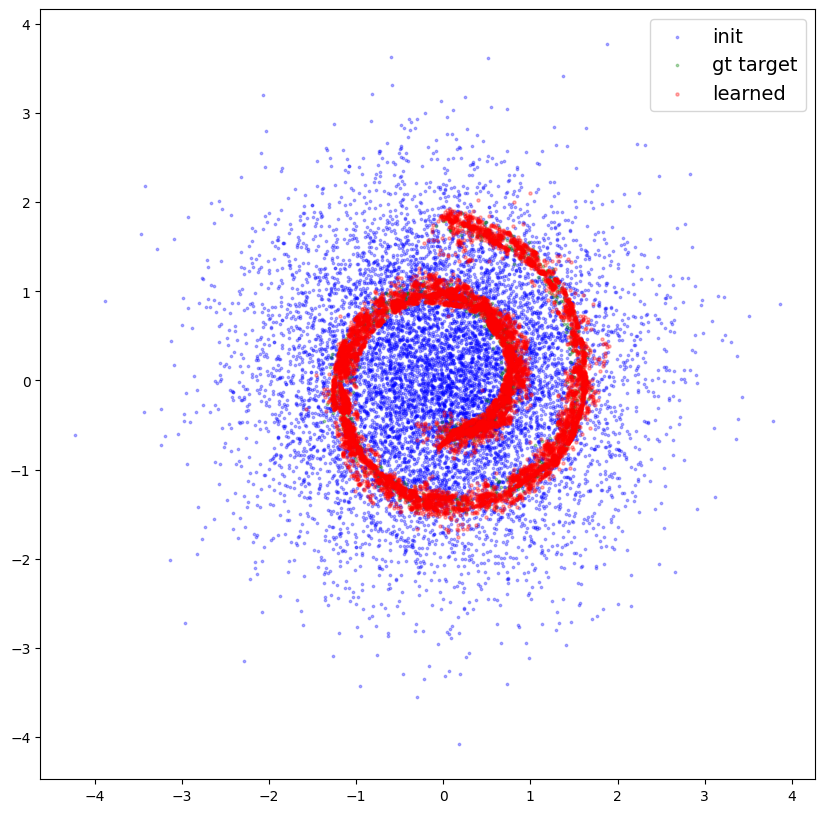

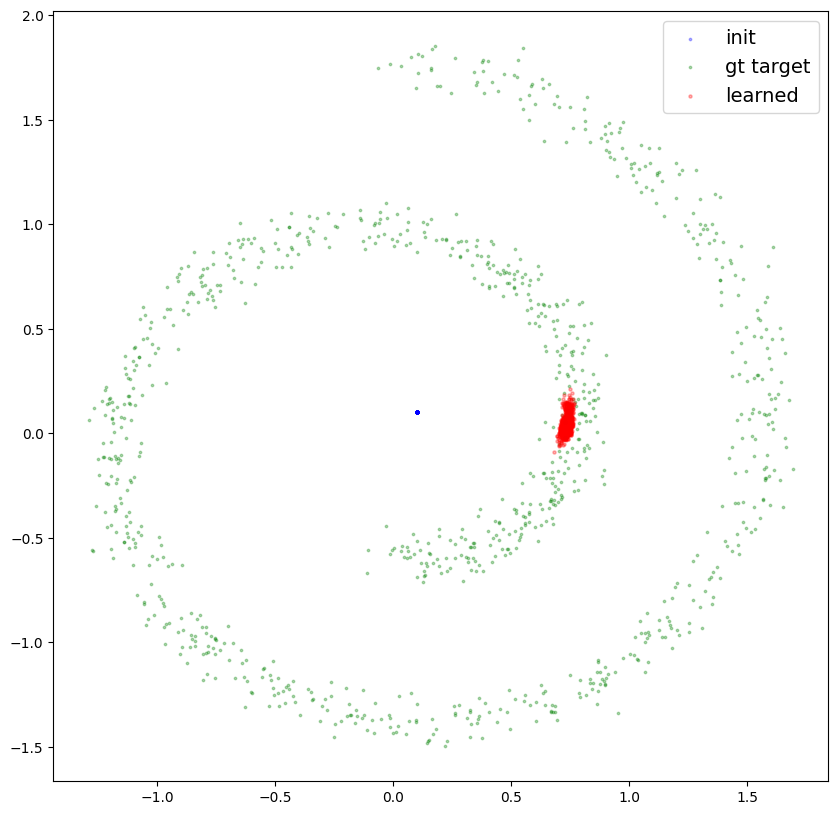

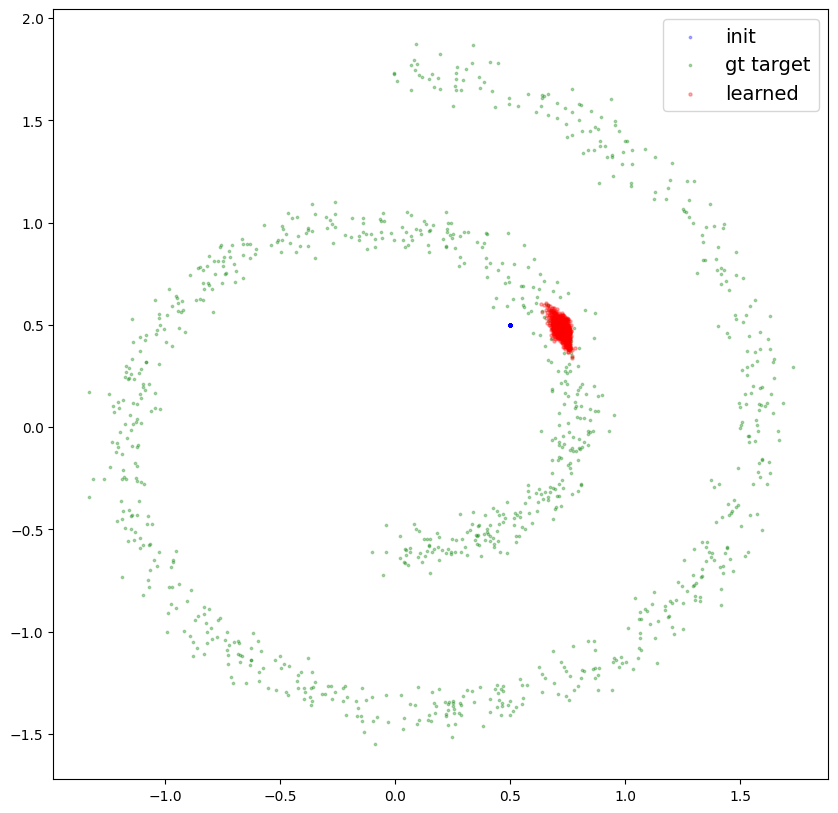

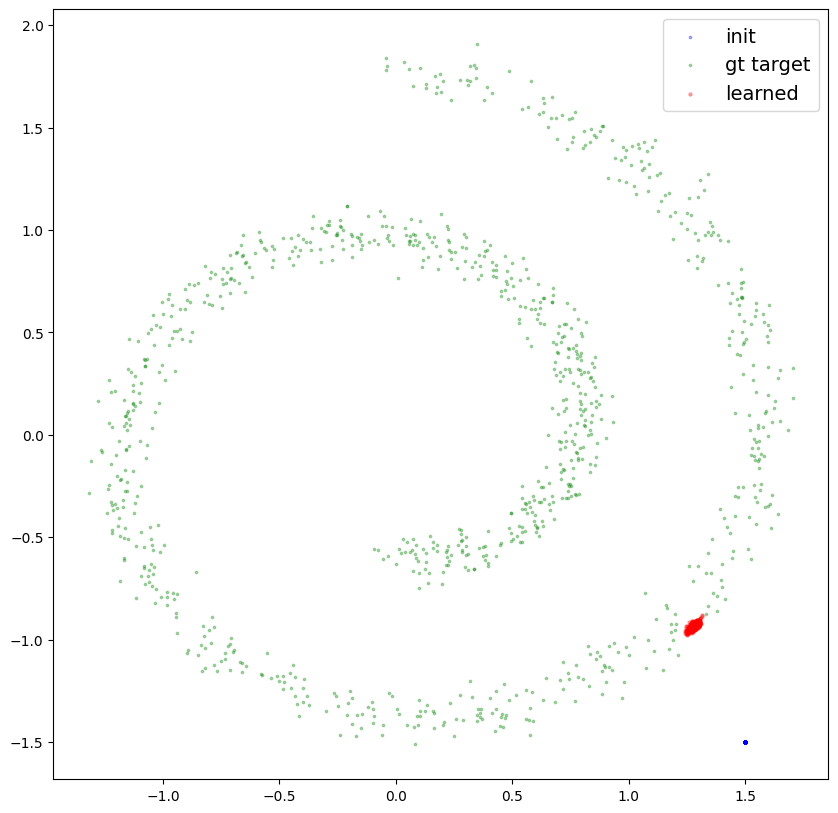

In [28]:
Xs = [
    StdGauss_sampler.sample(10000), 
    torch.tensor([[0.1, 0.1]]).to(DEVICE).repeat_interleave(1000, 0),
    torch.tensor([[0.5, 0.5]]).to(DEVICE).repeat_interleave(1000, 0),
    torch.tensor([[1.5, -1.5]]).to(DEVICE).repeat_interleave(1000, 0)]
for X in Xs:
    Y = gauss2swiss_eot.sample(X, n_iterations=5000, init_sampler=Distrib2Sampler(basic_noise_gen))
    np_Y_gt = SwissRoll_sampler.sample(1000).detach().cpu().numpy()
    np_X = X.detach().cpu().numpy()
    np_Y = Y.detach().cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.scatter(np_X[:, 0], np_X[:, 1], label='init', alpha=0.3, s=3, color='blue')
    plt.scatter(np_Y_gt[:, 0], np_Y_gt[:, 1], label='gt target', alpha=0.3, s=3, color='green')
    plt.scatter(np_Y[:, 0], np_Y[:, 1], label='learned', alpha=0.3, s=5, color='red')
    plt.legend(fontsize=14)
    plt.show()

### Discrete `OT` based on `sinkhorn` (as the baseline method)

In [20]:
X = StdGauss_sampler.sample(10000)
Y = SwissRoll_sampler.sample(10000)

In [22]:
discr_eot = DiscreteEOT_l2sq(dtype='torch64', numItermax=100000, device=DEVICE).solve(X, Y, 1e-3)

#### Loading pretrained DOT model

In [26]:
file_name = 'discrete_gaussian2swissroll_hreg_0.001'
path = os.path.join('../pretrained/gauss2swissroll/', file_name)
discr_eot = load_discrete_ot(path)

Visualize conditional samples from DOT model

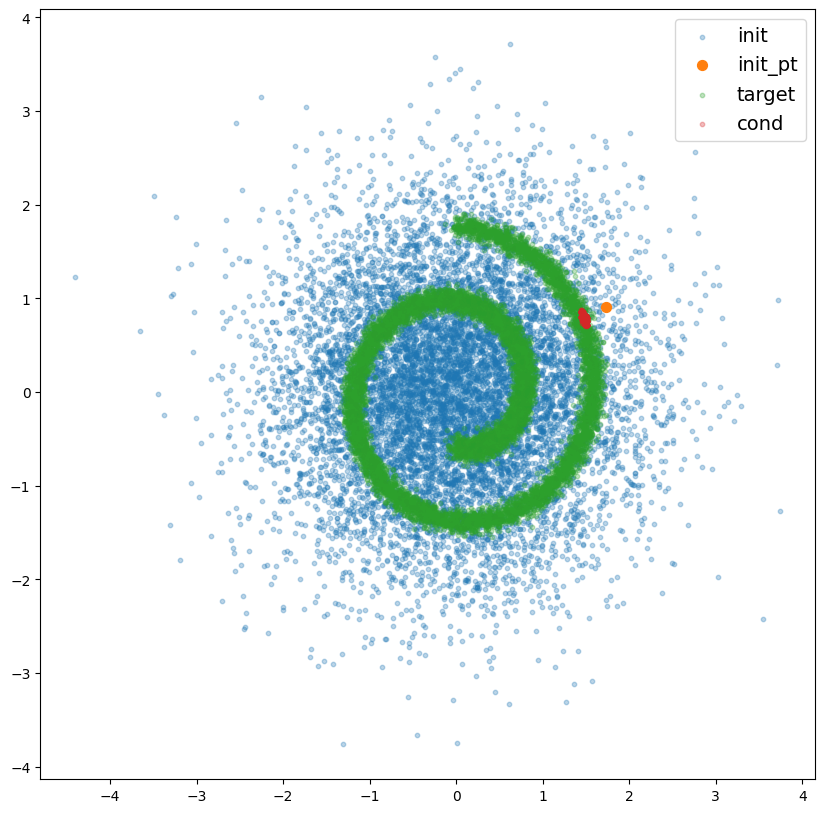

In [27]:
X = discr_eot.X
Y = discr_eot.Y

pt_index = 2
Y_X = discr_eot.sample_by_index(pt_index, 1000)

plt.figure(figsize=(10, 10))
plt.scatter(make_numpy(X)[:, 0], make_numpy(X)[:, 1], label='init', alpha=0.3, s=10)
plt.scatter(make_numpy(X[pt_index])[0], make_numpy(X[pt_index])[1], label='init_pt', s=50)
plt.scatter(make_numpy(Y)[:, 0], make_numpy(Y)[:, 1], label='target', alpha=0.3, s=10)
plt.scatter(make_numpy(Y_X)[:, 0], make_numpy(Y_X)[:, 1], label='cond', alpha=0.3, s =10)
plt.legend(fontsize=14)
plt.show()